# tabnet and catboost ensemble

## Colab 환경 구성

In [ ]:
# ================================================================================ #
# =========================== Goolge Colab File Upload =========================== #
# ================================================================================ #

from google.colab import drive
drive.mount('/content/drive')

# 출력값 초기화
from google.colab import output
output.clear()

# 경로 수정
import os
os.chdir("drive/MyDrive/Colab Notebooks/잡케어 추천 알고리즘 경진 대회")

In [ ]:
# model architecture
!pip install pytorch-tabnet==3.1.1
!pip install catboost

## Load Data from google Drive
- train_csv : train.csv 파일을 참조한 pandas 데이터
- test_csv : test.csv 파일을 참조한 pandas 데이터
- sample_submission : sample_submission.csv 파일을 참조한 pandas 데이터
- unknown1/2/3_csv : 추가 데이터

In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
import torch
import tensorflow as tf
import glob2
import json

train_csv = pd.read_csv('./dataset2/train.csv') 
test_csv = pd.read_csv('./dataset2/test.csv')
property_d_code = pd.read_csv('./dataset2/속성_D_코드.csv')
property_l_code = pd.read_csv('./dataset2/속성_L_코드.csv')
property_h_code = pd.read_csv('./dataset2/속성_H_코드.csv')
sample_submission = pd.read_csv('./dataset2/sample_submission.csv')

In [ ]:
df = train_csv.copy(...)

## Preprocessing

- train_csv 데이터프레임의 bool(True, False)형태의 데이터를 0과 1로 변경

In [ ]:
df['target'] = df['target'].apply(lambda x : int(x)).astype('int64')

bool_cols = ['d_l_match_yn','d_m_match_yn','d_s_match_yn','h_l_match_yn','h_m_match_yn','h_s_match_yn']

for bool_col in bool_cols:
    df[bool_col] = df[bool_col].apply(lambda x : int(x)).astype('int64')

In [ ]:
property_d_code.rename(columns = {
    "속성 D 코드" : "attribute_d_code",
    "속성 D 세분류코드":"attribute_d_d",
    "속성 D 소분류코드":"attribute_d_s",
    "속성 D 중분류코드":"attribute_d_m",
    "속성 D 대분류코드":"attribute_d_l",
}, inplace = True)
property_d_code.columns

Index(['attribute_d_code', 'attribute_d_d', 'attribute_d_s', 'attribute_d_m',
       'attribute_d_l'],
      dtype='object')

In [ ]:
property_h_code.rename(columns = {
    "속성 H 코드" : "attribute_h_code",
    "속성 H 중분류코드" : "attribute_h_m",
    "속성 H 대분류코드" : "attribute_h_l",   
}, inplace = True)
property_h_code.columns

Index(['attribute_h_code', 'attribute_h_m', 'attribute_h_l'], dtype='object')

In [ ]:
property_l_code.rename(columns = {
    "속성 L 코드" : "attribute_l_code",
    "속성 L 세분류코드":"attribute_l_d",
    "속성 L 소분류코드":"attribute_l_s",
    "속성 L 중분류코드":"attribute_l_m",
    "속성 L 대분류코드":"attribute_l_l",
}, inplace = True)
property_l_code.columns

Index(['attribute_l_code', 'attribute_l_d', 'attribute_l_s', 'attribute_l_m',
       'attribute_l_l'],
      dtype='object')

In [ ]:
code_d = property_d_code.copy(...)
code_h = property_h_code.copy(...)
code_l = property_l_code.copy(...)

In [ ]:
def merge_dataframe(df, df_added, col):
    df_copy = df.copy(...)
    df_added_copy = df_added.copy(...)
    
    df_added_copy = df_added_copy.add_prefix(f"{col}_")
    df_added_copy.columns.values[0] = col

    return pd.merge(df_copy, df_added_copy, how = 'left', on = col)

In [ ]:
def preprocess_data(df_origin, cols_merge, cols_equi, cols_drop):
    df = df_origin.copy(...)

    # merge data
    for col, df_code in cols_merge:
        df = merge_dataframe(df, df_code, col)

    # boolean type convert to int type
    cols = df.select_dtypes(bool).columns.tolist()
    df[cols] = df[cols].astype(int)

    for col1, col2 in cols_equi:
        df[f"{col1}_{col2}"] = (df[col1] == df[col2] ).astype(int)

    df = df.drop(columns=cols_drop)
    
    return df

- 똑같은 행이 대다수인 column들이 존재함, 변별력이 없다고 판단

In [ ]:
# 변별력이 없는 column 추가
cols_drop = []
columns = df.columns.tolist()
for col in columns:
    if len(np.unique(df[col].values)) == 1:
        print("col :{} detected".format(col))
        cols_drop.append(col)

# 그 외 columns 중 범주형 변수가 아닌 요소 제외
cols_drop.extend(['id', 'contents_open_dt','person_rn','contents_rn'])
print(cols_drop)

col :person_prefer_f detected
col :person_prefer_g detected
['person_prefer_f', 'person_prefer_g', 'id', 'contents_open_dt', 'person_rn', 'contents_rn']


In [ ]:
cols_merge = [
              ("person_prefer_d_1" , code_d),
              ("person_prefer_d_2" , code_d),
              ("person_prefer_d_3" , code_d),
              ("contents_attribute_d" , code_d),
              ("person_prefer_h_1" , code_h),
              ("person_prefer_h_2" , code_h),
              ("person_prefer_h_3" , code_h),
              ("contents_attribute_h" , code_h),
              ("contents_attribute_l" , code_l),
]

In [ ]:
cols_equi = [
    ("contents_attribute_c","person_prefer_c"),
    ("contents_attribute_e","person_prefer_e"),
    ("person_prefer_d_2_attribute_d_s" , "contents_attribute_d_attribute_d_s"),
    ("person_prefer_d_2_attribute_d_m" , "contents_attribute_d_attribute_d_m"),
    ("person_prefer_d_2_attribute_d_l" , "contents_attribute_d_attribute_d_l"),
    ("person_prefer_d_3_attribute_d_s" , "contents_attribute_d_attribute_d_s"),
    ("person_prefer_d_3_attribute_d_m" , "contents_attribute_d_attribute_d_m"),
    ("person_prefer_d_3_attribute_d_l" , "contents_attribute_d_attribute_d_l"),
    ("person_prefer_h_1_attribute_h_m" , "contents_attribute_h_attribute_h_m"),
    ("person_prefer_h_2_attribute_h_m" , "contents_attribute_h_attribute_h_m"),
    ("person_prefer_h_3_attribute_h_m" , "contents_attribute_h_attribute_h_m"),
    ("person_prefer_h_1_attribute_h_l" , "contents_attribute_h_attribute_h_l"),
    ("person_prefer_h_2_attribute_h_l" , "contents_attribute_h_attribute_h_l"),
    ("person_prefer_h_3_attribute_h_l" , "contents_attribute_h_attribute_h_l"),
]

- 코드D,L,H 그리고 train 데이터를 하나의 데이터프레임으로 합치며, bool형태의 데이터는 0과 1로 변경하도록 함

In [ ]:
df_preprocessed = preprocess_data(df, cols_merge, cols_equi, cols_drop)

In [ ]:
output.clear()

## Catboost Model Train

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import f1_score

import torch
from pytorch_tabnet.tab_model  import TabNetClassifier 
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.metrics import Metric
from sklearn.preprocessing import LabelEncoder
import catboost
from catboost import CatBoostClassifier, Pool

x_cols = df_preprocessed.columns.drop(['target']).tolist()
y_cols = ['target']

categorical_feature = df_preprocessed[x_cols].columns[df_preprocessed[x_cols].nunique() > 2].to_list()
print("num of categorical feature : {}".format(len(categorical_feature)))
df_train, df_test = train_test_split(df_preprocessed, test_size = 0.2, random_state = 42)

num of categorical feature : 47


In [ ]:
# train-test split
x_train, y_train = df_train[x_cols], df_train[y_cols]
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2)
x_test, y_test = df_test[x_cols], df_test[y_cols]

# catboost
cbc = CatBoostClassifier(
    random_seed = 42,
    task_type = 'GPU',
    devices = '0:1',
    custom_metric = ['Logloss','F1'],
)

d_train = Pool(x_train, y_train, feature_names = list(x_train.columns), cat_features = categorical_feature)
d_valid = Pool(x_valid, y_valid, feature_names = list(x_valid.columns), cat_features = categorical_feature)
d_test = Pool(x_test, y_test, feature_names = list(x_test.columns), cat_features = categorical_feature)

cbc.fit(d_train, eval_set = d_valid, verbose = False)

## TabNet Model Train

In [ ]:
from pytorch_tabnet.pretraining import TabNetPretrainer

x_train_tab = x_train.copy(...)
x_valid_tab = x_valid.copy(...)
x_test_tab = x_test.copy(...)

# preprocessing for TabNet
cat_idxs = []
cat_dims = []
for idx, col in enumerate(x_train_tab.columns):
    if 'match' not in col and col!='target': # match -> boolean의 경우, 굳이 label encoder를 거칠 필요가 없다
        le = LabelEncoder()
        le.fit(x_train_tab[col].values)
        le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
        x_train_tab[col] = x_train_tab[col].apply(lambda x: le_dict.get(x, len(le_dict)))
        x_valid_tab[col] = x_valid_tab[col].apply(lambda x: le_dict.get(x, len(le_dict)))
        x_test_tab[col] = x_test_tab[col].apply(lambda x: le_dict.get(x, len(le_dict)))
        cat_idxs.append(idx)
        cat_dims.append(len(le_dict)+1)

# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    optimizer_fn=torch.optim.AdamW,
    optimizer_params=dict(lr=1e-3),
    mask_type='entmax' # "sparsemax"
)

unsupervised_model.fit(
    X_train=x_train_tab.values,
    eval_set=[x_valid_tab.values],
    pretraining_ratio=0.8,
    max_epochs=12, 
    patience=4,
)

clf = TabNetClassifier(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=3,
                       n_d = 8,
                       scheduler_fn = torch.optim.lr_scheduler.StepLR,
                       scheduler_params = {'gamma':0.9,'step_size':8},
                       optimizer_fn=torch.optim.AdamW, # Any optimizer works here
                       optimizer_params=dict(lr=1e-3),
                       mask_type='entmax', # "sparsemax",
                       device_name='cuda',
                      )

class F1_Score(Metric):
    def __init__(self):
        self._name = "f1"
        self._maximize = True

    def __call__(self, y_true, y_score):
        score = f1_score(y_true, (y_score[:, 1]>0.5)*1)
        return score

clf.fit(
    X_train=x_train_tab.values, y_train=y_train.values.reshape(-1,),
    eval_set=[(x_train_tab.values, y_train.values.reshape(-1,)), (x_valid_tab.values, y_valid.values.reshape(-1,))],
    eval_name=['train', 'val'],
    eval_metric=['logloss','f1'],
    max_epochs=100 , patience=8,
    batch_size=1024,
    virtual_batch_size=256,
    num_workers=4,
    drop_last=False,
    from_unsupervised=unsupervised_model
) 

Device used : cuda
epoch 0  | loss: 2.29694 | val_0_unsup_loss: 1.08377 |  0:00:23s
epoch 1  | loss: 1.05434 | val_0_unsup_loss: 1.02138 |  0:00:45s
epoch 2  | loss: 1.01407 | val_0_unsup_loss: 1.00589 |  0:01:06s
epoch 3  | loss: 1.00472 | val_0_unsup_loss: 0.99978 |  0:01:30s
epoch 4  | loss: 1.00107 | val_0_unsup_loss: 0.99481 |  0:01:52s
epoch 5  | loss: 0.9982  | val_0_unsup_loss: 0.98696 |  0:02:16s
epoch 6  | loss: 0.99302 | val_0_unsup_loss: 0.97394 |  0:02:37s
epoch 7  | loss: 0.98749 | val_0_unsup_loss: 0.96401 |  0:03:00s
epoch 8  | loss: 0.98268 | val_0_unsup_loss: 0.95475 |  0:03:21s
epoch 9  | loss: 0.97784 | val_0_unsup_loss: 0.94371 |  0:03:43s
epoch 10 | loss: 0.97034 | val_0_unsup_loss: 0.92704 |  0:04:04s
epoch 11 | loss: 0.96001 | val_0_unsup_loss: 0.90568 |  0:04:25s
Stop training because you reached max_epochs = 12 with best_epoch = 11 and best_val_0_unsup_loss = 0.90568
Best weights from best epoch are automatically used!
Device used : cuda


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 3 to 1
  warnings.warn(wrn_msg)


Loading weights from unsupervised pretraining
epoch 0  | loss: 0.68786 | train_logloss: 0.67798 | train_f1: 0.59103 | val_logloss: 0.67813 | val_f1: 0.59125 |  0:00:20s
epoch 1  | loss: 0.67868 | train_logloss: 0.67465 | train_f1: 0.60835 | val_logloss: 0.67548 | val_f1: 0.60665 |  0:00:41s
epoch 2  | loss: 0.67564 | train_logloss: 0.67154 | train_f1: 0.60661 | val_logloss: 0.67281 | val_f1: 0.60461 |  0:01:02s
epoch 3  | loss: 0.673   | train_logloss: 0.6693  | train_f1: 0.62005 | val_logloss: 0.67096 | val_f1: 0.61677 |  0:01:22s
epoch 4  | loss: 0.67092 | train_logloss: 0.66749 | train_f1: 0.61664 | val_logloss: 0.66946 | val_f1: 0.61314 |  0:01:43s
epoch 5  | loss: 0.66947 | train_logloss: 0.66596 | train_f1: 0.61509 | val_logloss: 0.66812 | val_f1: 0.61102 |  0:02:04s
epoch 6  | loss: 0.668   | train_logloss: 0.66465 | train_f1: 0.61817 | val_logloss: 0.66683 | val_f1: 0.61475 |  0:02:25s
epoch 7  | loss: 0.66668 | train_logloss: 0.6633  | train_f1: 0.62418 | val_logloss: 0.66612 

## Catboost and TabNet Ensemble

- 두개의 모델에서 추론한 값을 앙상블함

# threshold : 0.15, train score : 0.678, valid score : 0.676, test score : 0.676
# threshold : 0.20, train score : 0.686, valid score : 0.682, test score : 0.682
# threshold : 0.25, train score : 0.695, valid score : 0.687, test score : 0.688
# threshold : 0.30, train score : 0.707, valid score : 0.693, test score : 0.694
# threshold : 0.35, train score : 0.721, valid score : 0.697, test score : 0.699
# threshold : 0.40, train score : 0.739, valid score : 0.698, test score : 0.702
# threshold : 0.45, train score : 0.752, valid score : 0.690, test score : 0.694
# threshold : 0.50, train score : 0.752, valid score : 0.663, test score : 0.668
# threshold : 0.60, train score : 0.623, valid score : 0.489, test score : 0.490
# threshold : 0.70, train score : 0.249, valid score : 0.156, test score : 0.154
# threshold : 0.80, train score : 0.014, valid score : 0.005, test score : 0.006


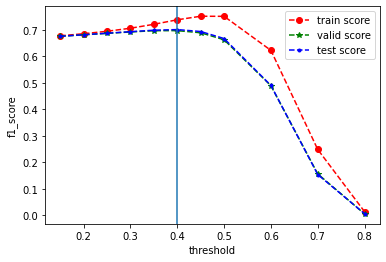

In [ ]:
# prediction for tabnet and catboost
preds_train_tab = clf.predict_proba(x_train_tab.values)
preds_valid_tab = clf.predict_proba(x_valid_tab.values)
preds_test_tab = clf.predict_proba(x_test_tab.values)

preds_train_cbc = cbc.predict_proba(x_train)
preds_valid_cbc = cbc.predict_proba(x_valid)
preds_test_cbc = cbc.predict_proba(x_test)

preds_train = (preds_train_tab + preds_train_cbc) / 2
preds_valid = (preds_valid_tab + preds_valid_cbc) / 2
preds_test = (preds_test_tab + preds_test_cbc) / 2

threshold_list = [0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.6,0.7,0.8]

train_score_tab_list = []
valid_score_tab_list = []
test_score_tab_list = []

train_score_cbc_list = []
valid_score_cbc_list = []
test_score_cbc_list = []

train_score_ensemble_list = []
valid_score_ensemble_list = []
test_score_ensemble_list = []

for threshold in threshold_list:
    preds_train_tab_binary = (preds_train_tab[:,1]>=threshold)*1
    preds_valid_tab_binary = (preds_valid_tab[:,1]>=threshold)*1
    preds_test_tab_binary = (preds_test_tab[:,1]>=threshold)*1

    preds_train_cbc_binary = (preds_train_cbc[:,1]>=threshold)*1
    preds_valid_cbc_binary = (preds_valid_cbc[:,1]>=threshold)*1
    preds_test_cbc_binary = (preds_test_cbc[:,1]>=threshold)*1

    train_score_tab = f1_score(y_train.values.reshape(-1,1), preds_train_tab_binary.reshape(-1,1))
    valid_score_tab = f1_score(y_valid.values.reshape(-1,1), preds_valid_tab_binary.reshape(-1,1))
    test_score_tab = f1_score(y_test.values.reshape(-1,1), preds_test_tab_binary.reshape(-1,1))

    train_score_cbc = f1_score(y_train.values.reshape(-1,1), preds_train_cbc_binary.reshape(-1,1))
    valid_score_cbc = f1_score(y_valid.values.reshape(-1,1), preds_valid_cbc_binary.reshape(-1,1))
    test_score_cbc = f1_score(y_test.values.reshape(-1,1), preds_test_cbc_binary.reshape(-1,1))

    train_score_tab_list.append(train_score_tab)
    valid_score_tab_list.append(valid_score_tab)
    test_score_tab_list.append(test_score_tab)

    train_score_cbc_list.append(train_score_cbc)
    valid_score_cbc_list.append(valid_score_cbc)
    test_score_cbc_list.append(test_score_cbc)

    preds_train_binary = (preds_train[:,1]>=threshold)*1
    preds_valid_binary = (preds_valid[:,1]>=threshold)*1
    preds_test_binary = (preds_test[:,1]>=threshold)*1

    train_score = f1_score(y_train.values.reshape(-1,1), preds_train_binary.reshape(-1,1))
    valid_score = f1_score(y_valid.values.reshape(-1,1), preds_valid_binary.reshape(-1,1))
    test_score = f1_score(y_test.values.reshape(-1,1), preds_test_binary.reshape(-1,1))

    print("# threshold : {:.2f}, train score : {:.3f}, valid score : {:.3f}, test score : {:.3f}".format(threshold, train_score, valid_score, test_score))

    train_score_ensemble_list.append(train_score)
    valid_score_ensemble_list.append(valid_score)
    test_score_ensemble_list.append(test_score)

experiment = pd.DataFrame({
    'threshold':threshold_list, 
    'train_score_tab':train_score_tab_list,
    'valid_score_tab':valid_score_tab_list,
    'test_score_tab':test_score_tab_list,
    'train_score_cbc':train_score_cbc_list,
    'valid_score_cbc':valid_score_cbc_list,
    'test_score_cbc':test_score_cbc_list,
    'train_score_ensemble':train_score_ensemble_list,
    'valid_score_ensemble':valid_score_ensemble_list,
    'test_score_ensemble':test_score_ensemble_list,
})

import matplotlib.pyplot as plt

plt.plot(experiment.threshold, experiment.train_score_ensemble, 'ro--', label ="train score")
plt.plot(experiment.threshold, experiment.valid_score_ensemble, 'g*--', label ="valid score")
plt.plot(experiment.threshold, experiment.test_score_ensemble, 'b.--', label ="test score")

idx_max = np.argmax(experiment.test_score_ensemble.values)
plt.axvline(x=experiment.threshold.values[idx_max])

plt.xlabel("threshold")
plt.ylabel("f1_score")
plt.legend()
plt.show()

- ensemble 모델에서 threshold값을 주어 0과 1의 trade-off를 나타내었을 때, 0.4에서 train, valid, test의 f1 score가 가장 높은 점수를 얻음

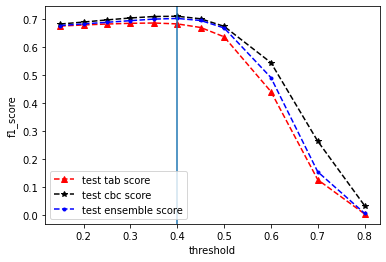

In [ ]:
plt.plot(experiment.threshold, experiment.test_score_tab, 'r^--', label ="test tab score")
plt.plot(experiment.threshold, experiment.test_score_cbc, 'k*--', label ="test cbc score")
plt.plot(experiment.threshold, experiment.test_score_ensemble, 'b.--', label ="test ensemble score")

idx_max = np.argmax(experiment.test_score_ensemble.values)
plt.axvline(x=experiment.threshold.values[idx_max])

plt.xlabel("threshold")
plt.ylabel("f1_score")
plt.legend()
plt.show()

- tabnet, catboost, ensemble 모델로 testset을 추론하였을때도 0.4에서 가장 높은 점수를 얻음

In [ ]:
experiment[["threshold","test_score_tab","test_score_cbc","test_score_ensemble"]]

,threshold,test_score_tab,test_score_cbc,test_score_ensemble
0,0.15,0.674341,0.681534,0.676211
1,0.20,0.678280,0.688719,0.682052
2,0.25,0.681657,0.696284,0.687841
3,0.30,0.684202,0.703196,0.693619
4,0.35,0.685224,0.708428,0.699164
5,0.40,0.682102,0.709399,0.701527
6,0.45,0.669205,0.700275,0.694230
7,0.50,0.636021,0.673448,0.667701
8,0.60,0.440484,0.543804,0.490490
9,0.70,0.125842,0.263275,0.153984


## Submission
- testset을 추론하여 제출파일을 생성

In [ ]:
def stacking_ensemble(df_train, df_test, num_k_fold = 4, params = None):

    model_list_cbc = []
    model_list_tab = []

    threshold_list = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.6,0.7,0.8]

    x_train, y_train = df_train[x_cols].reset_index(drop = True), df_train[y_cols].reset_index(drop = True)
    x_test, y_test = df_test[x_cols].reset_index(drop = True), df_test[y_cols].reset_index(drop = True)

    x_train_tab = x_train.copy(...)
    x_test_tab = x_test.copy(...)

    # tabnet preprocessing
    cat_idxs = []
    cat_dims = []
    for idx, col in enumerate(x_train_tab.columns):
        if 'match' not in col and col!='target': # match -> boolean의 경우, 굳이 label encoder를 거칠 필요가 없다
            le = LabelEncoder()
            le.fit(x_train_tab[col].values)
            le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
            x_train_tab[col] = x_train_tab[col].apply(lambda x: le_dict.get(x, len(le_dict)))
            x_test_tab[col] = x_test_tab[col].apply(lambda x: le_dict.get(x, len(le_dict)))
            cat_idxs.append(idx)
            cat_dims.append(len(le_dict)+1)

    # catboost preprocessing
    catboost_features = x_train.columns[x_train.nunique() > 2].tolist()

    # list for training and prediction
    preds_tab = []
    preds_tab_test = []

    preds_cbc = []
    preds_cbc_test = []

    val_idxs = []
    k_fold = KFold(n_splits = num_k_fold, shuffle = True)

    for idx, (tr_idx, val_idx) in enumerate(k_fold.split(x_train)):
        tr_x_tab, tr_y = x_train_tab.iloc[tr_idx], y_train.iloc[tr_idx]
        val_x_tab, val_y = x_train_tab.iloc[val_idx], y_train.iloc[val_idx]

        # TabNetPretrainer
        unsupervised_model = TabNetPretrainer(
            cat_idxs=cat_idxs,
            cat_dims=cat_dims,
            optimizer_fn=torch.optim.AdamW,
            optimizer_params=dict(lr=1e-3),
            mask_type='entmax' # "sparsemax"
        )

        unsupervised_model.fit(
            X_train=tr_x_tab.values,
            eval_set=[val_x_tab.values],
            pretraining_ratio=0.8,
            max_epochs=12, 
            patience=4,
        )

        # tabnet training
        clf = TabNetClassifier(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=3,
                       optimizer_fn=torch.optim.AdamW, # Any optimizer works here
                       mask_type='entmax', # "sparsemax",
                       scheduler_fn = torch.optim.lr_scheduler.StepLR,
                       scheduler_params = {'gamma':0.9,'step_size':8},
                      )
        clf.fit(
            X_train=tr_x_tab.values, y_train=tr_y.values.reshape(-1,),
            eval_set=[(tr_x_tab.values, tr_y.values.reshape(-1,)), (val_x_tab.values, val_y.values.reshape(-1,))],
            eval_name=['train', 'val'],
            eval_metric=['logloss','f1'],
            max_epochs=100 , patience=8,
            batch_size=1024,
            virtual_batch_size=256,
            num_workers=4,
            drop_last=False,
        ) 

        tr_x, tr_y = x_train.iloc[tr_idx], y_train.iloc[tr_idx]
        val_x, val_y = x_train.iloc[val_idx], y_train.iloc[val_idx]

        # catboost training
        d_train = Pool(tr_x, tr_y, feature_names = list(tr_x.columns), cat_features = catboost_features)
        d_valid = Pool(val_x, val_y, feature_names = list(val_x.columns), cat_features = catboost_features)

        cbc = CatBoostClassifier(
            random_seed = 42,
            task_type = 'GPU',
            devices = '0:1',
            custom_metric = ['Logloss','F1'],
        )

        cbc.fit(d_train, eval_set = d_valid)

        # predict valid set and test set
        pred_tab = clf.predict_proba(val_x_tab.values)[:,1].reshape(-1,)
        pred_tab_test = clf.predict_proba(x_test_tab.values)[:,1].reshape(-1,)

        pred_cbc = cbc.predict_proba(val_x.values)[:,1].reshape(-1,)
        pred_cbc_test = cbc.predict_proba(x_test.values)[:,1].reshape(-1,)

        val_idxs.append(val_idx)

        preds_tab.append(pred_tab)
        preds_tab_test.append(pred_tab_test)

        preds_cbc.append(pred_cbc)
        preds_cbc_test.append(pred_cbc_test)

        model_list_tab.append(clf)
        model_list_cbc.append(cbc)
    
    val_idxs = np.concatenate(val_idxs)
    order = np.argsort(val_idxs)
    
    # post-processing catboost
    preds_cbc = np.concatenate(preds_cbc, axis = 0)
    preds_cbc = preds_cbc[order]
    preds_cbc_test = np.mean(preds_cbc_test, axis = 0)

    # post-processing tabnet 
    preds_tab = np.concatenate(preds_tab, axis = 0)
    preds_tab = preds_tab[order]
    preds_tab_test = np.mean(preds_tab_test, axis = 0)

    # ensemble
    preds = (preds_cbc + preds_tab) / 2   
    preds_test = (preds_cbc_test + preds_tab_test) / 2  

    threshold_select = None  
    train_score_select = None  
    test_score_select = None  

    for threshold in threshold_list:
        preds_binary = preds >= threshold
        preds_test_binary = preds_test >= threshold

        train_score = f1_score(y_train['target'].values.reshape(-1,1), preds_binary.reshape(-1,1))
        test_score = f1_score(y_test['target'].values.reshape(-1,1), preds_test_binary.reshape(-1,1))

        print("# threshold : {:.3f}, f1_score for train set : {:.3f} and test set : {:.3f}".format(threshold, train_score, test_score))

        if threshold_select is None:
            threshold_select = threshold
            train_score_select = train_score
            test_score_select = test_score

        if test_score_select <= test_score:
            threshold_select = threshold
            train_score_select = train_score
            test_score_select = test_score
            
    return preds, preds_test, train_score_select, test_score_select, threshold_select, model_list_cbc, model_list_tab

In [ ]:
preds, preds_test, train_score, test_score, threshold, model_list_cbc, model_list_tab = stacking_ensemble(
    df_train,
    df_test,
    num_k_fold = 8
)

In [ ]:
import time

# submission
df_submission = test_csv.copy(...)

for bool_col in bool_cols:
    df_submission[bool_col] = df_submission[bool_col].apply(lambda x : int(x)).astype('int64')

df_submission = preprocess_data(df_submission, cols_merge, cols_equi, cols_drop)
x_submission = df_submission[x_cols]

def stacking_ensemble_submission(df, df_submission, num_k_fold = 4):

    model_list_cbc = []
    model_list_tab = []
    threshold_list = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.6,0.7,0.8]

    x_train, y_train = df[x_cols].reset_index(drop = True), df[y_cols].reset_index(drop = True)
    x_submission = df_submission[x_cols]

    x_train_tab = x_train.copy(...)
    x_submission_tab = x_submission.copy(...)

    cat_idxs = []
    cat_dims = []
    for idx, col in enumerate(x_train_tab.columns):
        if 'match' not in col and col!='target': 
            le = LabelEncoder()
            le.fit(x_train_tab[col].values)
            le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
            x_train_tab[col] = x_train_tab[col].apply(lambda x: le_dict.get(x, len(le_dict)))
            x_submission_tab[col] = x_submission_tab[col].apply(lambda x: le_dict.get(x, len(le_dict)))
            cat_idxs.append(idx)
            cat_dims.append(len(le_dict)+1)

    # catboost preprocessing
    catboost_features = x_train.columns[x_train.nunique() > 2].tolist()

    # list for training and prediction
    preds_tab = []
    preds_tab_sub = []

    preds_cbc = []
    preds_cbc_sub = []

    val_idxs = []

    k_fold = KFold(n_splits = num_k_fold, shuffle = True)

    start_time = time.time()
    end_time = None

    for idx, (tr_idx, val_idx) in enumerate(k_fold.split(x_train)):

        tr_x_tab, tr_y = x_train_tab.iloc[tr_idx], y_train.iloc[tr_idx]
        val_x_tab, val_y = x_train_tab.iloc[val_idx], y_train.iloc[val_idx]

        # TabNetPretrainer
        unsupervised_model = TabNetPretrainer(
            cat_idxs=cat_idxs,
            cat_dims=cat_dims,
            optimizer_fn=torch.optim.AdamW,
            optimizer_params=dict(lr=1e-3),
            mask_type='entmax' # "sparsemax"
        )

        unsupervised_model.fit(
            X_train=tr_x_tab.values,
            eval_set=[val_x_tab.values],
            pretraining_ratio=0.8,
            max_epochs=12, 
            patience=4,
        )

        # tabnet training
        clf = TabNetClassifier(
            cat_idxs=cat_idxs,
            cat_dims=cat_dims,
            cat_emb_dim=3,
            optimizer_fn=torch.optim.AdamW, # Any optimizer works here
            mask_type='entmax', # "sparsemax",
            scheduler_fn = torch.optim.lr_scheduler.StepLR,
            scheduler_params = {'gamma':0.95,'step_size':8},
        )
        
        clf.fit(
            X_train=tr_x_tab.values, y_train=tr_y.values.reshape(-1,),
            eval_set=[(tr_x_tab.values, tr_y.values.reshape(-1,)), (val_x_tab.values, val_y.values.reshape(-1,))],
            eval_name=['train', 'val'],
            eval_metric=['logloss'],
            max_epochs=32 , patience=6,
            batch_size=1024,
            virtual_batch_size=256,
            num_workers=4,
            drop_last=False,
        )

        tr_x, tr_y = x_train.iloc[tr_idx], y_train.iloc[tr_idx]
        val_x, val_y = x_train.iloc[val_idx], y_train.iloc[val_idx]

        # catboost training
        d_train = Pool(tr_x, tr_y, feature_names = list(tr_x.columns), cat_features = catboost_features)
        d_valid = Pool(val_x, val_y, feature_names = list(val_x.columns), cat_features = catboost_features)

        cbc = CatBoostClassifier(
            random_seed = 42,
            task_type = 'GPU',
            devices = '0:1',
            custom_metric = ['Logloss','F1'],
        )

        cbc.fit(d_train, eval_set = d_valid, verbose = False)

        # predict valid set and test set
        pred_tab = clf.predict_proba(val_x_tab.values)[:,1].reshape(-1,)
        pred_tab_sub = clf.predict_proba(x_submission_tab.values)[:,1].reshape(-1,)

        pred_cbc = cbc.predict_proba(val_x.values)[:,1].reshape(-1,)
        pred_cbc_sub = cbc.predict_proba(x_submission.values)[:,1].reshape(-1,)

        val_idxs.append(val_idx)

        preds_tab.append(pred_tab)
        preds_tab_sub.append(pred_tab_sub)

        preds_cbc.append(pred_cbc)
        preds_cbc_sub.append(pred_cbc_sub)

        model_list_tab.append(clf)
        model_list_cbc.append(cbc)

        if end_time is None:
            end_time = time.time()
            dt = end_time - start_time
            m = int(dt * (num_k_fold - 1) // 60 )
            s = int(dt * (num_k_fold - 1) % 60 )
            print("time last : {:2d}m {:2d}s".format(m,s))
        print("# process : {:d} / {:d} complete...".format(idx+1, num_k_fold))

    val_idxs = np.concatenate(val_idxs)
    order = np.argsort(val_idxs)
    
    # post-processing catboost
    preds_cbc = np.concatenate(preds_cbc, axis = 0)
    preds_cbc = preds_cbc[order]
    preds_cbc_sub = np.mean(preds_cbc_sub, axis = 0)

    # post-processing tabnet 
    preds_tab = np.concatenate(preds_tab, axis = 0)
    preds_tab = preds_tab[order]
    preds_tab_sub = np.mean(preds_tab_sub, axis = 0)

    # ensemble
    preds = (preds_cbc + preds_tab) / 2   
    preds_sub = (preds_cbc_sub + preds_tab_sub) / 2  

    threshold_select = None  
    train_score_select = None  

    for threshold in threshold_list:
        preds_binary = preds >= threshold
        preds_sub_binary = preds_sub >= threshold

        train_score = f1_score(y_train['target'].values.reshape(-1,1), preds_binary.reshape(-1,1))

        print("# threshold : {:.3f}, f1_score for train set : {:.3f}".format(threshold, train_score))

        if threshold_select is None:
            threshold_select = threshold
            train_score_select = train_score

        if train_score >= train_score_select:
            threshold_select = threshold
            train_score_select = train_score
           
    result = {
        "preds_cbc" : preds_cbc,
        "preds_tab" : preds_tab,
        "preds" : preds,
        "target_train":y_train,
        "preds_cbc_sub" : preds_cbc_sub,
        "preds_tab_sub" : preds_tab_sub,
        "preds_sub" : preds_sub,
        "threshold":threshold_select,
        "train_score_select":train_score_select
    }

    return result, model_list_cbc, model_list_tab

result, model_list_cbc, model_list_tab = stacking_ensemble_submission(df_preprocessed, df_submission, num_k_fold = 8)

Device used : cuda
epoch 0  | loss: 2.64159 | val_0_unsup_loss: 1.12274 |  0:00:28s
epoch 1  | loss: 1.0396  | val_0_unsup_loss: 1.04257 |  0:00:56s
epoch 2  | loss: 1.00965 | val_0_unsup_loss: 1.01831 |  0:01:24s
epoch 3  | loss: 1.00106 | val_0_unsup_loss: 1.00042 |  0:01:52s
epoch 4  | loss: 0.99494 | val_0_unsup_loss: 0.98099 |  0:02:20s
epoch 5  | loss: 0.98607 | val_0_unsup_loss: 0.95196 |  0:02:48s
epoch 6  | loss: 0.95795 | val_0_unsup_loss: 0.91374 |  0:03:16s
epoch 7  | loss: 0.91536 | val_0_unsup_loss: 0.86912 |  0:03:44s
epoch 8  | loss: 0.87373 | val_0_unsup_loss: 0.81812 |  0:04:13s
epoch 9  | loss: 0.83258 | val_0_unsup_loss: 0.74899 |  0:04:41s
epoch 10 | loss: 0.79201 | val_0_unsup_loss: 0.70167 |  0:05:09s
epoch 11 | loss: 0.75808 | val_0_unsup_loss: 0.66132 |  0:05:37s
Stop training because you reached max_epochs = 12 with best_epoch = 11 and best_val_0_unsup_loss = 0.66132
Best weights from best epoch are automatically used!
Device used : cuda
epoch 0  | loss: 0.684

In [ ]:
preds_tab = result['preds_tab']
preds_cbc = result['preds_cbc']
y_train = result['target_train']

weights = [0.5, 0.6, 0.7, 0.8, 0.9]
threshold_list = [0.1,0.15,0.2,0.25,0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 0.45,0.5,0.6,0.7,0.8]

data_col_weight = []
data_col_threshold = []
data_col_score = []

for threshold in threshold_list:
    for weight in weights:
        preds_ws = weight * preds_tab + (1-weight) * preds_cbc
        preds_ws_binary = preds_ws >= threshold
        score = f1_score(y_train['target'].values.reshape(-1,1), preds_ws_binary.reshape(-1,1))

        data_col_weight.append(weight)
        data_col_threshold.append(threshold)
        data_col_score.append(score)

df_summary = pd.DataFrame({"weight":data_col_weight, "threshold":data_col_threshold, "score":data_col_score})

In [ ]:
df_summary[df_summary['score'] >= 0.7]

,weight,threshold,score
25,0.5,0.325,0.702313
26,0.6,0.325,0.700160
30,0.5,0.350,0.704850
31,0.6,0.350,0.702428
35,0.5,0.375,0.706151
36,0.6,0.375,0.703414
37,0.7,0.375,0.700710
40,0.5,0.400,0.705943
41,0.6,0.400,0.703157
45,0.5,0.425,0.703874


In [ ]:
argmax_idx = np.argmax(df_summary.score.values)
df_summary.iloc[argmax_idx]

weight       0.500000
threshold    0.375000
score        0.706151
Name: 35, dtype: float64

In [ ]:
weight = 0.5
threshold = 0.375
preds_sub = weight * result['preds_tab_sub'] + (1-weight) * result['preds_cbc_sub']
preds_sub_binary = preds_sub >= threshold

In [ ]:
sample_submission["target"] = np.array([int(x) for x in preds_sub_binary])

# submission 
from google.colab import files
sample_submission.to_csv("submission_0102_tab_cbc.csv", index = False)
files.download("submission_0102_tab_cbc.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>